Esse notebook utiliza dados históricos das ações da Microsoft ([Kaggle Dataset](https://www.kaggle.com/datasets/vijayvvenkitesh/microsoft-stock-time-series-analysis)) para prever preços usando Prophet e LSTM.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.preprocessing import MinMaxScaler
from prophet import Prophet
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense

In [2]:
# Carregar os dados
df = pd.read_csv('Microsoft_Stock.csv')
df['Date'] = pd.to_datetime(df['Date'])
df.set_index('Date', inplace=True)

# Usar apenas a coluna de fechamento
dados = df[['Close']]

# 1. Modelo utilizando Prophet
O Prophet é popular por sua fácil configuração e eficiência em séries temporais com tendência e sazonalidade, ajustando curvas suaves e prevendo o futuro com pouca necessidade de ajustes manuais.

In [3]:
# Preparar os dados para o Prophet
df_prophet = dados.reset_index()
df_prophet.columns = ['ds', 'y']

In [4]:
# Criar e ajustar o modelo
modelo_prophet = Prophet()
modelo_prophet.fit(df_prophet)

DEBUG:cmdstanpy:input tempfile: /tmp/tmpxjubchp_/i7kh7fu4.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpxjubchp_/le0hsdr5.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=68268', 'data', 'file=/tmp/tmpxjubchp_/i7kh7fu4.json', 'init=/tmp/tmpxjubchp_/le0hsdr5.json', 'output', 'file=/tmp/tmpxjubchp_/prophet_modele81q6v7v/prophet_model-20250324113159.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
11:31:59 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
11:32:00 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


In [5]:
# Criar previsões futuras
futuro = modelo_prophet.make_future_dataframe(periods=365)
previsao_prophet = modelo_prophet.predict(futuro)

In [6]:
# Pegar previsões para o período de teste
previsoes_prophet = previsao_prophet[['ds', 'yhat']].set_index('ds')
previsoes_prophet = previsoes_prophet.loc[dados.index]

# 2. Modelo utilizando LSTM
As redes LSTM são muito boas para previsões de séries temporais porque elas conseguem lembrar informações de longo prazo. Isso é útil para ações, já que o preço de um dia pode ser influenciado por muitos dias anteriores.

In [7]:
# Normalizar os dados
scaler = MinMaxScaler(feature_range=(0, 1))
dados_normalizados = scaler.fit_transform(dados)

In [8]:
# Criar sequências
def criar_sequencias(dados, passo):
    X, y = [], []
    for i in range(len(dados) - passo):
        X.append(dados[i:(i + passo), 0])
        y.append(dados[i + passo, 0])
    return np.array(X), np.array(y)

passo = 60
X, y = criar_sequencias(dados_normalizados, passo)
X = X.reshape((X.shape[0], X.shape[1], 1))

In [9]:
# Criar modelo LSTM
modelo_lstm = Sequential([
    LSTM(50, return_sequences=True, input_shape=(X.shape[1], 1)),
    LSTM(50),
    Dense(1)
])
modelo_lstm.compile(optimizer='adam', loss='mean_squared_error')

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [10]:
# Treinar o modelo
modelo_lstm.fit(X, y, epochs=20, batch_size=32, verbose=1)

Epoch 1/20
46/46 ━━━━━━━━━━━━━━━━━━━━ 9s 58ms/step - loss: 0.0616
Epoch 2/20
46/46 ━━━━━━━━━━━━━━━━━━━━ 5s 57ms/step - loss: 6.0400e-04
Epoch 3/20
46/46 ━━━━━━━━━━━━━━━━━━━━ 5s 61ms/step - loss: 4.5741e-04
Epoch 4/20
46/46 ━━━━━━━━━━━━━━━━━━━━ 3s 58ms/step - loss: 4.0987e-04
Epoch 5/20
46/46 ━━━━━━━━━━━━━━━━━━━━ 5s 63ms/step - loss: 4.5679e-04
Epoch 6/20
46/46 ━━━━━━━━━━━━━━━━━━━━ 4s 83ms/step - loss: 5.1742e-04
Epoch 7/20
46/46 ━━━━━━━━━━━━━━━━━━━━ 4s 57ms/step - loss: 4.6977e-04
Epoch 8/20
46/46 ━━━━━━━━━━━━━━━━━━━━ 5s 61ms/step - loss: 4.7935e-04
Epoch 9/20
46/46 ━━━━━━━━━━━━━━━━━━━━ 5s 55ms/step - loss: 4.6989e-04
Epoch 10/20
46/46 ━━━━━━━━━━━━━━━━━━━━ 5s 56ms/step - loss: 4.4012e-04
Epoch 11/20
46/46 ━━━━━━━━━━━━━━━━━━━━ 6s 68ms/step - loss: 5.1429e-04
Epoch 12/20
46/46 ━━━━━━━━━━━━━━━━━━━━ 3s 56ms/step - loss: 4.2394e-04
Epoch 13/20
46/46 ━━━━━━━━━━━━━━━━━━━━ 5s 58ms/step - loss: 4.1928e-04
Epoch 14/20
46/46 ━━━━━━━━━━━━━━━━━━━━ 5s 55ms/step - loss: 3.8784e-04
Epoch 15/20
46/46 ━

In [11]:
# Fazer previsões
y_pred = modelo_lstm.predict(X)
y_pred = scaler.inverse_transform(y_pred.reshape(-1, 1))

dados_teste = dados.iloc[passo:]

46/46 ━━━━━━━━━━━━━━━━━━━━ 2s 32ms/step


# 3. Métricas de Avaliação e Comparação
Para comparar os modelos, eu utilizei algumas métricas de erro:

**Erro Médio Absoluto (MAE):** Mostra o erro médio em valores absolutos, ou seja, quanto a previsão errou em média.

**Erro Quadrático Médio (MSE):** Parecido com o MAE, mas penaliza mais erros grandes, porque ajuda a identificar previsões muito ruins.

**Raiz do Erro Quadrático Médio (RMSE):** É a raiz do MSE, então traz o erro para a mesma unidade dos dados originais.

**Erro Percentual Absoluto Médio (MAPE):** Porque mostra o erro médio em porcentagem e facilita a comparação com diferentes escalas de valores.

Referência: [Medium - Métricas de Regressão](https://medium.com/data-hackers/prevendo-n%C3%BAmeros-entendendo-m%C3%A9tricas-de-regress%C3%A3o-35545e011e70)

In [12]:
def calcular_metricas(valores_reais, previsoes, modelo):
    mae = mean_absolute_error(valores_reais, previsoes)
    mse = mean_squared_error(valores_reais, previsoes)
    rmse = np.sqrt(mse)
    mape = np.mean(np.abs((valores_reais - previsoes) / valores_reais)) * 100
    print(f'Métricas do modelo {modelo}:')
    print(f'MAE: {mae}')
    print(f'MSE: {mse}')
    print(f'RMSE: {rmse}')
    print(f'MAPE: {mape}%')

In [13]:
# Garantir que os tamanhos sejam iguais
previsoes_prophet = previsoes_prophet.loc[dados_teste.index]

# Avaliar Prophet
calcular_metricas(dados_teste['Close'], previsoes_prophet['yhat'], 'Prophet')

Métricas do modelo Prophet:
MAE: 3.6020354304622892
MSE: 26.080060596513473
RMSE: 5.106864066774587
MAPE: 3.656815658568275%


In [14]:
# Garantir que os tamanhos sejam iguais
y_pred = y_pred[:len(dados_teste)].flatten()  # Ajustar tamanho e achatar array se necessário

# Avaliar LSTM
calcular_metricas(dados_teste['Close'].values, y_pred, 'LSTM')

Métricas do modelo LSTM:
MAE: 2.356017622839246
MSE: 14.57473762495084
RMSE: 3.81768747083242
MAPE: 2.038952567684087%


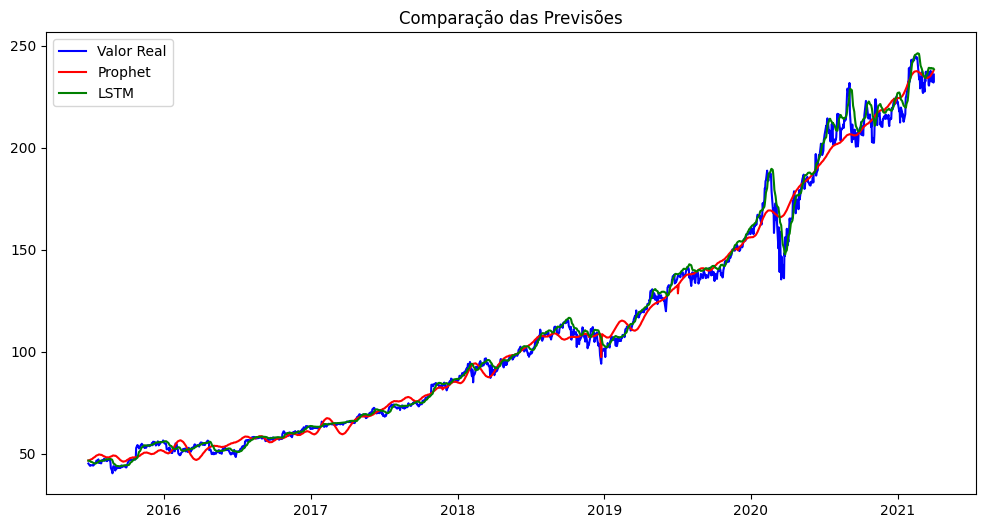

In [15]:
plt.figure(figsize=(12,6))
plt.plot(dados_teste.index, dados_teste['Close'], label='Valor Real', color='blue')
plt.plot(dados_teste.index, previsoes_prophet['yhat'], label='Prophet', color='red')
plt.plot(dados_teste.index, y_pred[:len(dados_teste)], label='LSTM', color='green')
plt.legend()
plt.title('Comparação das Previsões')
plt.show()

Com base nesses resultados, o modelo LSTM é a melhor escolha para previsão dessa série temporal, pois apresenta menor erro em todas as métricas.